In the machine learning domain, feature construction is always regarded as a critical component of a machine learning pipeline. Just as the deep neural network improves the performance of the traditional neural network through constructed features, if we can construct some powerful features, we may be able to significantly improve the learning capability of existing simple machine learning algorithms. In fact, in most ML competitions, feature engineering is always regarded as a critical point in winning the competition. Such features, however, necessitate a significant amount of effort on the part of domain experts. As a result, automated feature construction has become a hot topic in recent years. In general, we can generate several features using different methods, such as evolutionary algorithms or random search, and then select a few of them to use on the new machine learning system. In such a process, it is obvious that determining whether a feature is good or bad is a critical issue. As a result of this problem, most feature construction methods can be classified into three types: wrapper-based feature construction, filter-based feature construction, and embedded feature construction.
The difference between these three methods is depicted in the figure below. The first is the wrapper-based feature construction method. It is obvious that this method is based on a specific machine learning algorithm. To be more specific, for a set of features, we must build a machine learning model based on those features and then use the validation score as the score of those features. The second method, the filter-based construction method, does not rely on any machine learning algorithm. In contrast, it estimates the efficacy of each feature using a statistical measure, such as the Pearson correlation between that feature and the response variable. Finally, the third method, embedded feature construction, is only applicable to some machine learning algorithms, such as decision tree based methods, which can provide feature importance. As a result, we can use the feature's important value to select critical features.

These three methods each have their own set of benefits and drawbacks. The wrapper-based feature construction method, for example, is the most reliable method because it directly optimizes the validation score on a specific algorithm. The disadvantage is that it is extremely slow, especially when we need to construct some features for some expensive machine learning algorithms, such as neural networks or gradient boosted decision trees. In contrast, the filter-based construction method is quick because we don't need to train any machine learning algorithms during the scoring process. However, because it does not rely on any machine learning algorithms, the obtained result may not be applicable to the target algorithm. In terms of the last one, the embedded features construction method can, in fact, collaborate with the wrapper-based feature construction method. As a result, we will concentrate on comparing the first two methods in this article.

In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
import random

import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

random.seed(0)
np.random.seed(0)

X, y = load_diabetes(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In this article, I want to clear up a common misconception: unlike most people, I do not believe that the wrapper-based feature construction method is significantly slower than the filter-based feature construction method. In reality, the difference is not that great, and it should be within an order of magnitude. To demonstrate such an assumption, we run a scenario that evaluates a set of five features using Spearman correlation and a decision tree. As shown below, I repeated the experiment 1000 times to ensure the reliability of the experimental results. We can see that the Spearman correlation method must take two seconds to complete this process.

In [3]:
from scipy.stats import spearmanr
import time

st = time.time()
for i in range(1000):
    for j in range(5):
        pseudo_feature = np.random.rand(len(y_train))
        spearmanr(pseudo_feature, y_train)
print('time', time.time() - st)

time 0.6673939228057861


In comparison, if we build a decision tree based on the construction features and use the cross validation loss as the score of those features, the surprising thing is that we don't have to spend a lot of time on it. In reality, we only need to spend three more times to complete this task. The decision tree algorithm is, in fact, a lightning-fast algorithm. In theory, the decision tree's depth should be O(logN), where N represents the amount of data. Given such a fast algorithm, it's debatable whether we really need a less expensive but unreliable feature score estimation method.

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

st = time.time()
for i in range(1000):
    pseudo_feature = np.random.rand(len(y_train), 5)
    tree = DecisionTreeRegressor()
    cross_val_score(tree, pseudo_feature, y_train, cv=5)
print('time', time.time() - st)

time 5.939332962036133


To investigate the problem further, namely whether it is worthwhile to use three more times to find the useful features, we chose two frameworks in the genetic programming-based feature construction domain to validate the effectiveness of these two paradigms. The evolutionary forest is the first. It is a new framework based on a wrapper-based feature construction paradigm. This algorithm, like the illustrative example, evaluates features using a decision tree. As a result, the obtained features can be applied directly to tree-based algorithms. We found that it will take 27 seconds to obtain the results based on the experimental results.

In [5]:
from evolutionary_forest.forest import EvolutionaryForestRegressor

st = time.time()
r = EvolutionaryForestRegressor(max_height=8, normalize=True, select='AutomaticLexicase',
                                mutation_scheme='weight-plus-cross-global',
                                gene_num=10, boost_size=100, n_gen=20, base_learner='DT',
                                verbose=True)


# r = EvolutionaryForestRegressor(max_height=8, normalize=True, select='AutomaticLexicase',mutation_scheme='Tournament',
#                                 gene_num=10, boost_size=100, n_gen=20, n_pop=200, cross_pb=1,
#                                 base_learner='DT', verbose=True)
r.fit(x_train, y_train)
print('time', time.time() - st)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


   	      	                                fitness                                 	                      size                     
   	      	------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max     	min      	nevals	std     	avg  	gen	max	min	nevals	std    
0  	50    	0.110083	0  	0.561991	-0.118146	50    	0.143152	41.52	0  	54 	30 	50    	5.16233
1  	50    	0.0414098	1  	0.31671 	-0.225821	50    	0.112414	42.96	1  	56 	34 	50    	5.54603
2  	50    	-1.76804e-06	2  	0.330459	-0.205907	50    	0.0976501	43.16	2  	54 	34 	50    	4.64913
3  	50    	-0.0202674  	3  	0.188116	-0.251268	50    	0.0904962	45.64	3  	56 	36 	50    	5.31699
4  	50    	-0.0342732  	4  	0.138895	-0.246699	50    	0.080388 	46   	4  	60 	34 	50    	5.27636
5  	50    	-0.0472613  	5  	0.254234	-0.23676 	50    	0.103752 	47   	5  	62 	34 	50    	6.35295
6  	50    	-0.0736933  	6  	0.269744	-0.266423	50    	0.0920105	45.6 	6

The second is gplearn, which is a well-known genetic programming package. Unlike the previous package, this one employs the Spearman correlation coefficient to determine whether or not a feature is promising. As a result, this package has the advantage of being faster than the wrapper-based feature construction method. However, it is difficult to say whether the built feature is applicable to the target machine learning algorithm. Based on the experimental results, we found that it will take 8 seconds to obtain the results, demonstrating that this paradigm is significantly faster than the wrapper-based one.

In [6]:
from gplearn.genetic import SymbolicTransformer

st = time.time()
s = SymbolicTransformer(population_size=500, generations=20, hall_of_fame=500, n_components=50, metric='spearman',
                        verbose=1)
s.fit(x_train, y_train)
print('time', time.time() - st)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    28.81         0.145725        3         0.621013              N/A      3.45s
   1     5.47         0.423189        7         0.692754              N/A      2.39s
   2     4.46         0.545145       11         0.712732              N/A      2.64s
   3     6.60         0.552152       11         0.712732              N/A      2.18s
   4     7.96         0.602462       15          0.71876              N/A      1.98s
   5    11.39         0.622436       13          0.72161              N/A      1.86s
   6    11.46         0.609973       13          0.72161              N/A      1.72s
   7    12.30         0.597158       27         0.722578              N/A      1.68s
   8    12.44         0.606539       13          0.72161              N/A  

However, we should not focus solely on training time. In fact, whether its discovered features are useful or not is a more pressing concern. As a result, we build three decision models based on original features and those created by the evolutionary forest and gplearn, respectively.
According to the experimental results, the feature obtained by the wrapper-based method can significantly improve the performance of the random forest model. However, the features obtained by the filter-based method do not appear to be as significant.

In [7]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import r2_score
from evolutionary_forest.utils import get_feature_importance, feature_append


def score_func(score_name, model_name, x_train, x_test):
    scores = []
    for i in range(10):
        new_r = {
            'RF': RandomForestRegressor(),
            'AdaBoost': AdaBoostRegressor(),
            'GBDT': GradientBoostingRegressor(subsample=0.8, n_estimators=100),
            'DART': LGBMRegressor(boosting_type='DART', random_state=random.randint(0, 1000), n_estimators=100),
        }[model_name]
        new_r.fit(x_train, y_train)
        score = r2_score(y_test, new_r.predict(x_test))
        all_score.append((score_name, model_name, score))
        scores.append(score)
    return scores

In [8]:
code_importance_dict = get_feature_importance(r, simple_version=False)
new_train_wrapper = feature_append(r, x_train, list(code_importance_dict.keys())[:50], only_new_features=True)
new_test_wrapper = feature_append(r, x_test, list(code_importance_dict.keys())[:50], only_new_features=True)
all_score = []

wrapper_score = score_func('Wrapper', 'RF', new_train_wrapper, new_test_wrapper)
print('r2_score', wrapper_score, np.mean(wrapper_score))

r2_score [0.30367244360732903, 0.3338189801003538, 0.3331033966824323, 0.33333862961309824, 0.2986573914818219, 0.28405736777822643, 0.33519802301966783, 0.31929679059517746, 0.3217975718118258, 0.3068558277904718] 0.3169796422480405


In [9]:
base_score = score_func('Base', 'RF', x_train, x_test)
print('r2_score', base_score, np.mean(base_score))

r2_score [0.27137023983764963, 0.23680838477031685, 0.2818635119531069, 0.2742659431054616, 0.24412794917119895, 0.2846964991625698, 0.2706436779816789, 0.262651340461974, 0.30190275572272707, 0.2858981116004089] 0.27142284137670925


In [10]:
new_train = s.transform(x_train)
new_test = s.transform(x_test)
filter_score = score_func('Filter', 'RF', new_train, new_test)
print('r2_score', filter_score, np.mean(filter_score))

r2_score [0.32116110790921637, 0.27592307636383695, 0.30944742411735005, 0.2944304969458357, 0.29808010824921083, 0.30283152996025686, 0.30989172065504456, 0.2969699316687475, 0.2848503638211439, 0.293880233633551] 0.2987465993324193


To further solidify our conclusion, we must conduct a statistical test on the results. In this article, we will use the rank sum test to validate our assumption.

In [11]:
from scipy import stats

print('base_score vs wrapper_score', stats.ranksums(base_score, wrapper_score).pvalue)
print('base_score vs filter_score', stats.ranksums(base_score, filter_score).pvalue)
print('wrapper_score vs filter_score', stats.ranksums(wrapper_score, filter_score).pvalue)

base_score vs wrapper_score 0.00050654148469229
base_score vs filter_score 0.002496908915141548
wrapper_score vs filter_score 0.023342202012890816


Based on the statistical test, we can see that the best method, wrapper-based feature construction, outperforms its counterpart on this task significantly. Even though it costs twice as much, it is worthwhile to spend the extra time on this task.

In addition, we run these generated features through a variety of machine learning algorithms, including AdaBoost, GBDT, and DART. Based on the final results, we conclude that the features generated by the wrapped-based method are more useful, which can effectively improve the model prediction performance. In contrast, while the filter-based method can improve model performance, the effect is minor.

[0.34832488747102464, 0.32479995562289177, 0.39408046004529607, 0.35606036727086177, 0.3313985686967432, 0.38064332875558804, 0.359343873256065, 0.35327672665345844, 0.3564899977122814, 0.3831998852302665] [0.3042094950018627, 0.2317145036077095, 0.27219341769431704, 0.2519571856617986, 0.265158435463935, 0.30476424082632525, 0.2935622139297204, 0.24942031656108976, 0.2675759139866444, 0.22881474731961937] [0.2576051029011336, 0.2420848616910395, 0.2689687486643588, 0.2652804455813438, 0.29221693727009046, 0.2546080060668804, 0.26613302124102056, 0.30114094446187656, 0.28465531219771223, 0.2481522314995558]
[0.29050011312278956, 0.3419085543381595, 0.266505443027241, 0.21357672382888648, 0.284084125946076, 0.32260364070426595, 0.2988217167112276, 0.27627176947651455, 0.29086837494237616, 0.29274761038381314] [0.2148814195020845, 0.21486390162706337, 0.1928368054733196, 0.22552003198981863, 0.23123314061950895, 0.22468437035732713, 0.21075687471704652, 0.22489701684129793, 0.24467746769

<Axes: xlabel='Name', ylabel='Score'>

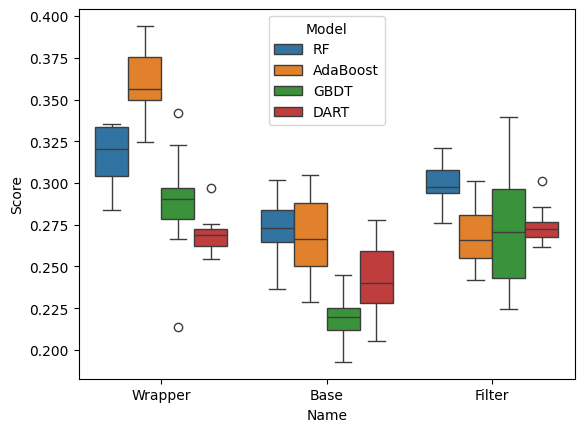

In [12]:
import seaborn as sns

for model in ['AdaBoost', 'GBDT', 'DART']:
    wrapper_score = score_func('Wrapper', model, new_train_wrapper, new_test_wrapper)
    base_score = score_func('Base', model, x_train, x_test)
    filter_score = score_func('Filter', model, new_train, new_test)
    print(wrapper_score, base_score, filter_score)
data = pd.DataFrame(all_score, columns=[
    'Name',
    'Model',
    'Score',
])
sns.boxplot(x='Name', y='Score', hue='Model', data=data)

Finally, in this article, we look at two popular paradigms in feature construction: the wrapper-based feature construction method and the filter-based feature construction method. The former is more accurate, while the latter is faster. In fact, the purpose of this article is not to argue that we should abandon the filter-based feature construction method; each method has its own set of application scenarios. It is obvious that the filter-based method is better suited to an environment with limited computational resources because it takes less time. The main point of this article is that many people believe that the wrapper-based method is slow. However, we show in this article that such a method is perfectly acceptable in most cases. In the future, we should not consider the feature construction method to be an A or B problem, in my opinion. Perhaps weighing the benefits of both and identifying the most applicable scenarios is the best solution for the development of machine learning techniques.